In [24]:
## Loading Libraries
import pandas as pd
import numpy as np
import sys
import jdatetime as jd
import os
import pickle
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display

# import power_index_calculator as px
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# **Loading OCM Data**

In [90]:
## Loading Data

OCM = ['Largest_Owner', 'First_Second','First_Sumtwofour', 'Sumfive',
       'Gini','Herfindahl', 'SSCL','SSCO', 'SSDL', 'SSDO', 'BZCL',
       'BZCO', 'BZDL',]

Start = 1390
End   = 1398 

os.chdir(r"C:\Users\Mahdi\OneDrive\Master Thesis\Data")
DATA = pd.read_csv('Data_For_IND_OCM.csv')
Data = DATA[['Symbol', 'Id_tse', 'Industry', 'sum_over1',
       'Num_holders', 'Marketcap', 'Largest_Owner', 'First_Second',
       'First_Sumtwofour', 'Sumfive', 'Sumfour', 'Sumthree', 'Sumtwo', 'Gini',
       'Herfindahl', 'SSCL', 'SSCO', 'SSDL', 'SSDO', 'BZCL', 'BZCO', 'BZDL',
       'Year']]

In [91]:
# Filling NA Marketcaps
Data = Data.sort_values(by=['Symbol','Year'])
Data['Marketcap'] = Data.groupby(['Symbol'], sort=True)['Marketcap'].apply(lambda x: x.ffill(limit=5).bfill(limit=5))
Data = Data[~pd.isnull(Data.Marketcap)]

# **Calculating Average for Industries and Filtering Industries**

In [105]:
## Calculating average for industries

wm = lambda x: np.average(x, weights=Data.loc[x.index, "Marketcap"])

Ind_OCM = Data.groupby(['Industry','Year'],as_index=False).agg({'Symbol':'count','Largest_Owner':'mean','First_Second':'mean',
                                                        'First_Sumtwofour':'mean','Sumfive':'mean','Gini':'mean',
                                                        'Herfindahl':'mean','SSCL':'mean','SSCO':'mean','SSDL':'mean',
                                                        'SSDO':'mean','BZCL':'mean','BZCO':'mean','BZDL':'mean'})

Ind_OCM_wm = Data.groupby(['Industry','Year'],as_index=False).agg({'Symbol':'count','Largest_Owner':wm,'First_Second':wm,
                                                        'First_Sumtwofour':wm,'Sumfive':wm,'Gini':wm,
                                                        'Herfindahl':wm,'SSCL':wm,'SSCO':wm,'SSDL':wm,
                                                        'SSDO':wm,'BZCL':wm,'BZCO':wm,'BZDL':wm})

Market_OCM_wm = Data.groupby(['Year'],as_index=False).agg({'Symbol':'count','Largest_Owner':'mean','First_Second':'mean',
                                                        'First_Sumtwofour':'mean','Sumfive':'mean','Gini':'mean',
                                                        'Herfindahl':'mean','SSCL':'mean','SSCO':'mean','SSDL':'mean',
                                                        'SSDO':'mean','BZCL':'mean','BZCO':'mean','BZDL':'mean'})

In [106]:
# Filtering industries and keeping with mean 5 symbols each year
min_sym = 20
temp = Ind_OCM[['Industry','Symbol']].groupby('Industry',as_index=False).agg('mean')
temp = temp[temp.Symbol>min_sym]

Ind_OCM = Ind_OCM[Ind_OCM.Industry.isin(temp.Industry)]
Ind_OCM.reset_index(drop=True,inplace=True)
Ind_OCM_wm = Ind_OCM_wm[Ind_OCM_wm.Industry.isin(temp.Industry)]
Ind_OCM_wm.reset_index(drop=True,inplace=True)

print("After filtering by year({}-{}), common stock, and keeping industries with average {} firms in each year:\n"
      "We have {:0.0f} Obs, and {} industries!"
      .format(Start,End,min_sym,len(Ind_OCM),len(Ind_OCM.Industry.drop_duplicates())))

# Ind_OCM
# Ind_OCM_wm

After filtering by year(1390-1398), common stock, and keeping industries with average 20 firms in each year:
We have 63 Obs, and 7 industries!


In [107]:
# Dictionary for Industries
temp = Ind_OCM['Industry'].drop_duplicates()
Ind_dict = dict(zip(temp,list(range(len(temp)))))
Ind_OCM['Industry_id'] = Ind_OCM['Industry'].map(Ind_dict)
Ind_OCM_wm['Industry_id'] = Ind_OCM_wm['Industry'].map(Ind_dict)

## **Plotting Results**

In [108]:
Ind_dict

{'انبوه سازی، املاک و مستغلات': 0,
 'خودرو و ساخت قطعات': 1,
 'سرمایه گذاریها': 2,
 'سیمان، آهک و گچ': 3,
 'فلزات اساسی': 4,
 'محصولات شیمیایی': 5,
 'مواد و محصولات دارویی': 6}

In [114]:
def plot_trend_Market(ocm):
        
    data = Market_OCM_wm[['Year',ocm]]

    
    ### Ploting the results 
    fig, ax1 = plt.subplots(1,1,figsize=(8,4), dpi= 90)

    ax1.plot(list(range(1390,1399)),data[ocm],lw=1,label=ocm)
    ax1.scatter(list(range(1390,1399)),data[ocm],s=[5],marker='o')

    ax1.tick_params(axis='x', labelsize=7)
    ax1.set_ylabel('Percentage',color='blue', fontsize=7)
    ax1.tick_params(axis='y', labelcolor='tab:blue',labelsize=7 )
    ax1.set_xticks(list(range(1390,1399)))
    ax1.set_xticklabels(list(range(1390,1399)))
    ax1.grid(alpha=.4,axis='x')
    ax1.grid(alpha=.4,axis='y')
    plt.title('{} through Time for Market'.format(ocm))
    # plt.suptitle('Marketcap weighted: {}'.format(weighted))
    plt.legend(fontsize=7,bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.savefig(ocm+'_Market.png',bbox_inches='tight')

In [117]:
def plot_trend(ocm,industries_id,weighted):
        
    if weighted:
        data = Ind_OCM_wm[['Year','Industry','Industry_id',ocm]]
    else:
        data = Ind_OCM[['Year','Industry','Industry_id',ocm]]

    data = data[data.Industry_id.isin(Industries_id)]  
    data = data.pivot(index='Year', columns='Industry', values=ocm)
    
    ### Ploting the results 
    fig, ax1 = plt.subplots(1,1,figsize=(8,4), dpi= 90)
    for column in list(data.columns):
        ar_char = get_display(arabic_reshaper.reshape(column))
        ax1.plot(list(range(1390,1399)),data[column],lw=1,label=ar_char)
        ax1.scatter(list(range(1390,1399)),data[column],s=[5],marker='o')

    ax1.tick_params(axis='x', labelsize=7)
    ax1.set_ylabel('Percentage',color='blue', fontsize=7)
    ax1.tick_params(axis='y', labelcolor='tab:blue',labelsize=7 )
    ax1.set_xticks(list(range(1390,1399)))
    ax1.set_xticklabels(list(range(1390,1399)))
    ax1.grid(alpha=.4,axis='x')
    ax1.grid(alpha=.4,axis='y')
    plt.title('{} through Time for Different Industries'.format(ocm))
    plt.savefig(ocm+'_Indust.png',bbox_inches='tight')

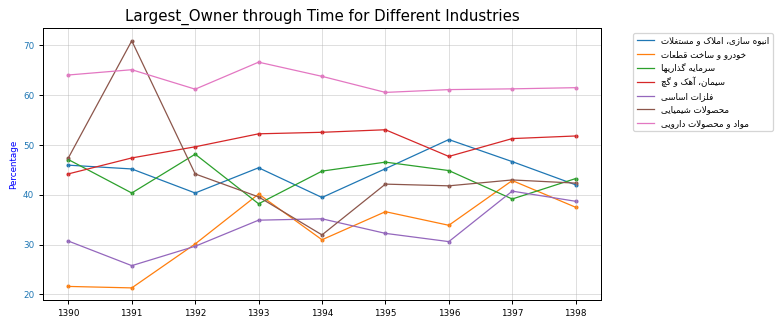

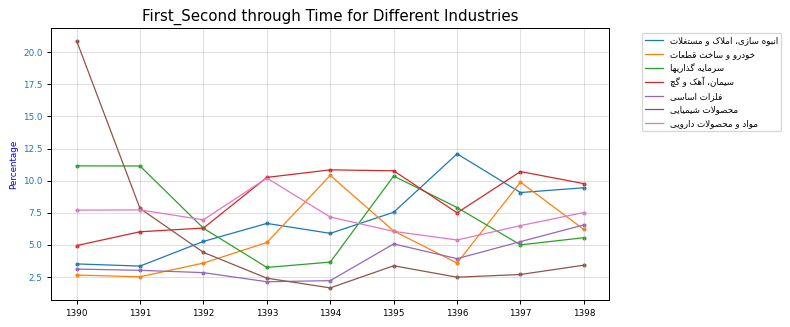

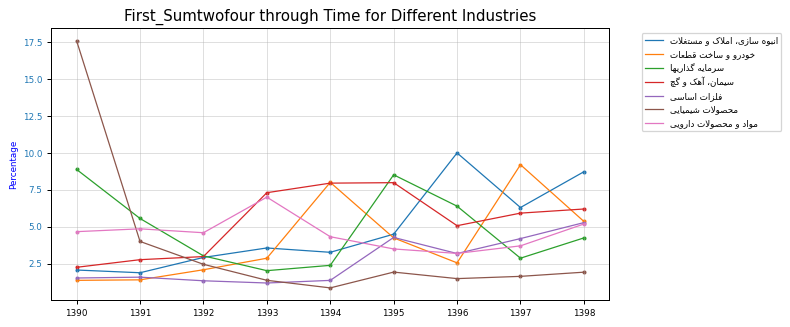

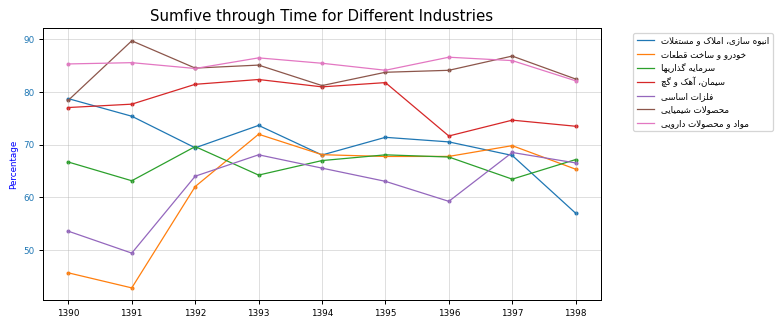

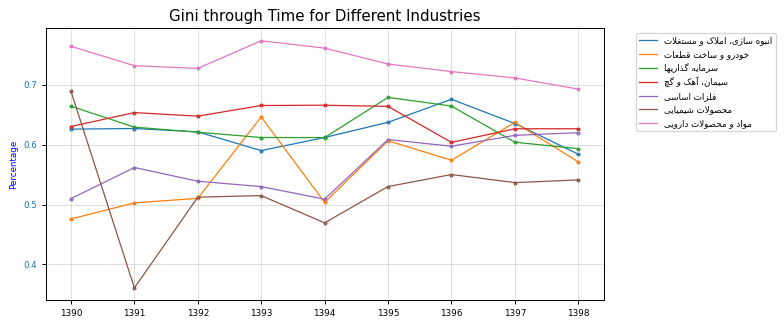

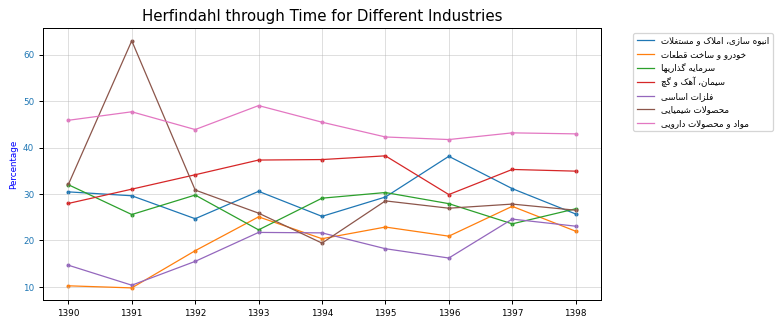

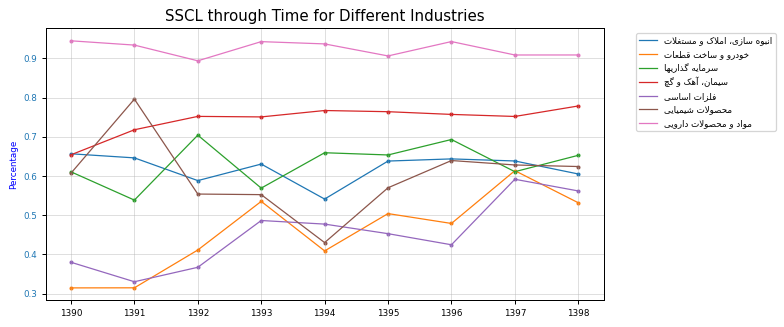

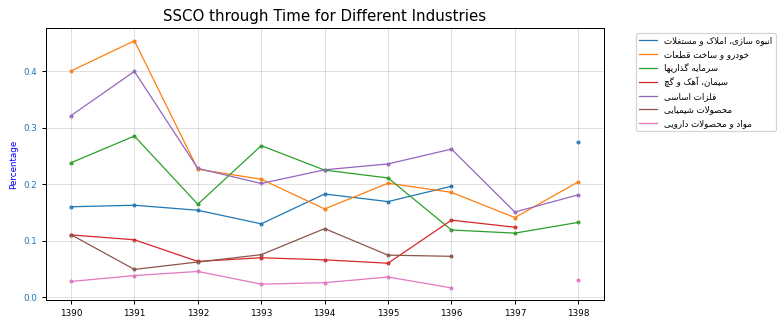

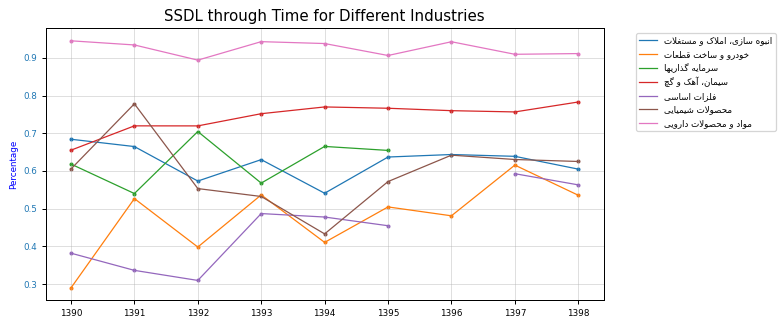

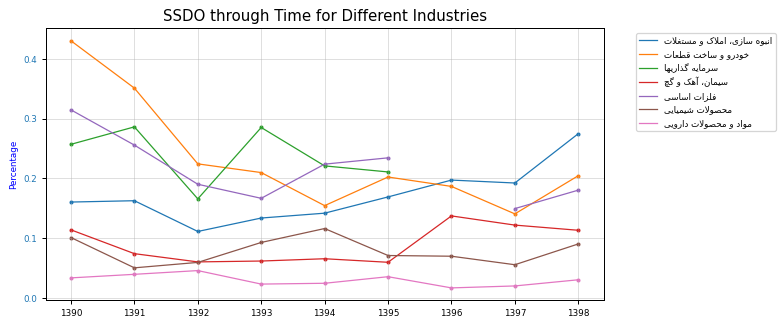

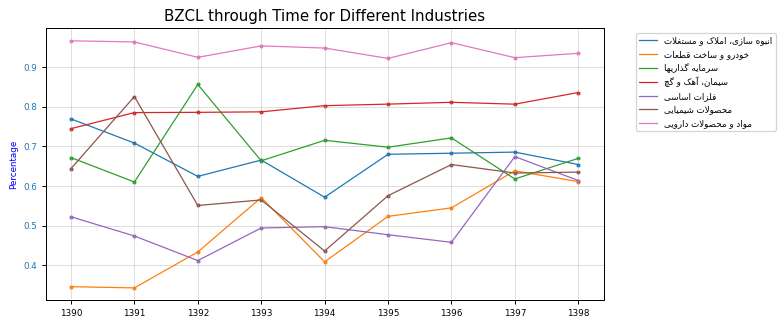

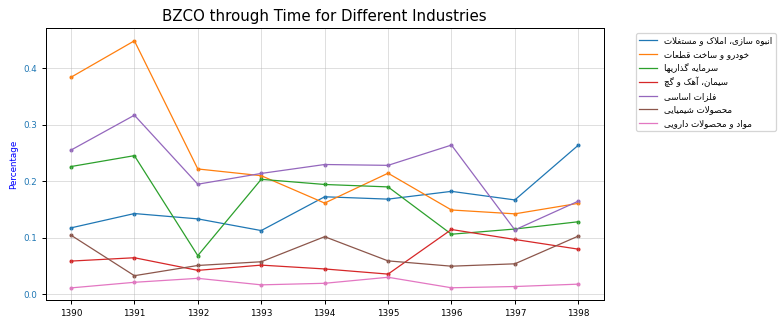

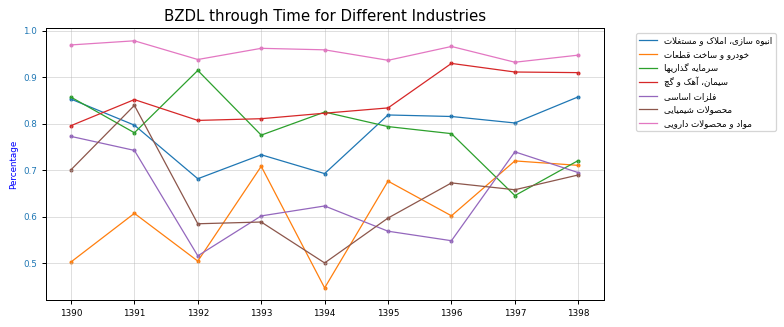

In [104]:
Industries_id = list(range(11))
weighted = True
os.chdir(r"C:\Users\Mahdi\OneDrive\Master Thesis\Codes\Concentration Through Time")
for ocm in OCM:
    plot_trend(ocm,Industries_id,weighted)


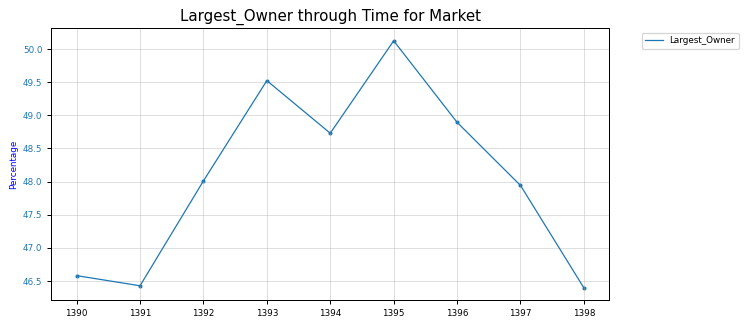

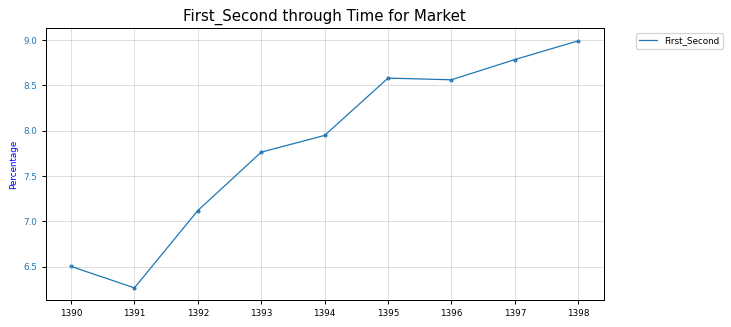

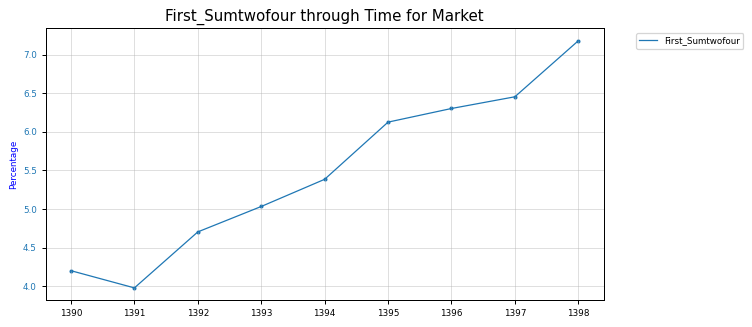

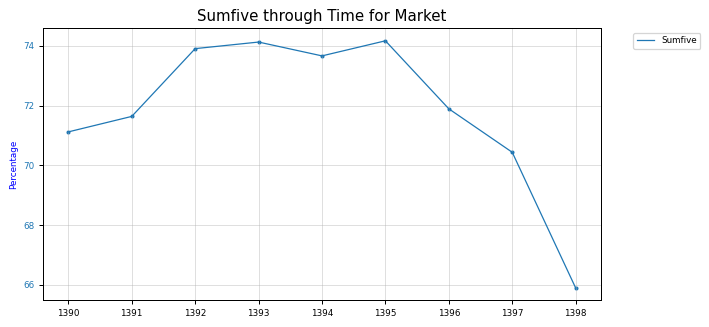

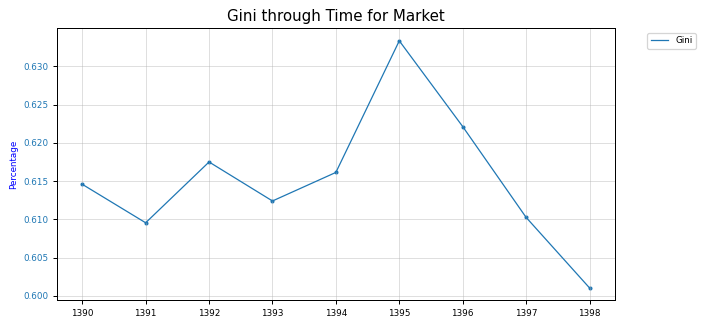

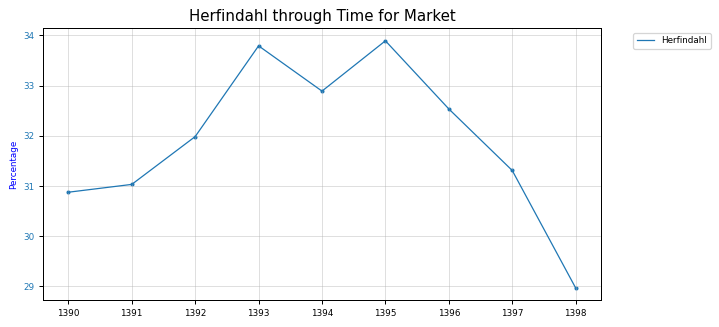

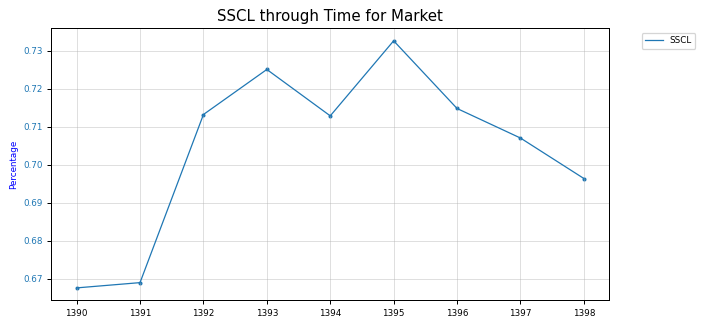

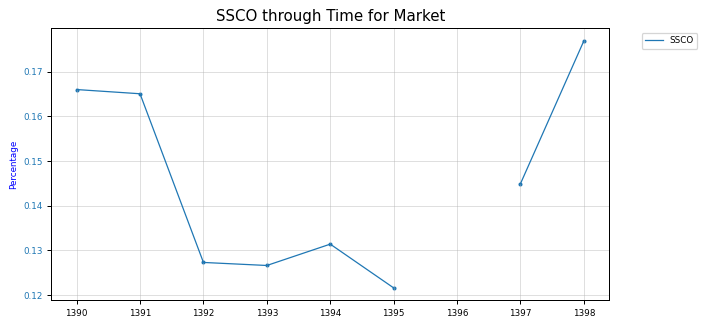

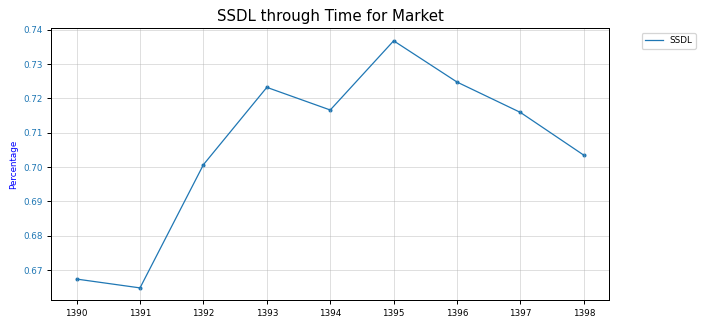

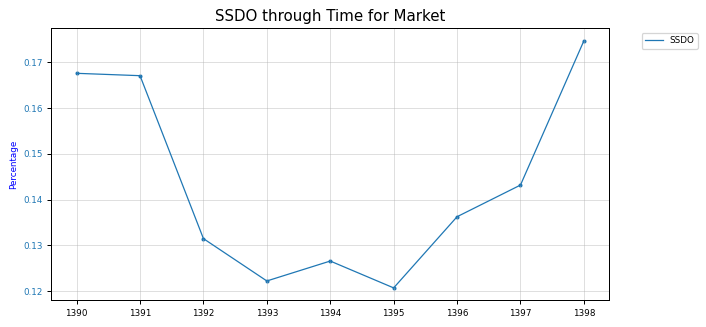

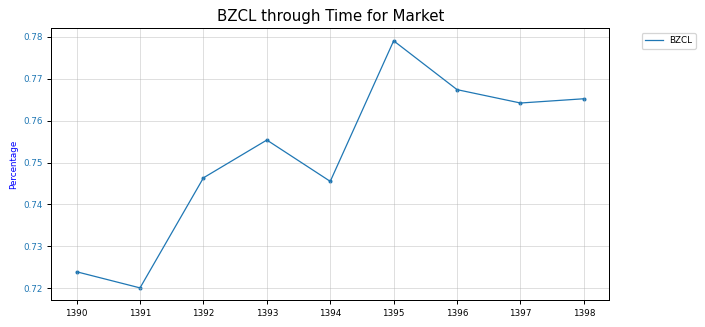

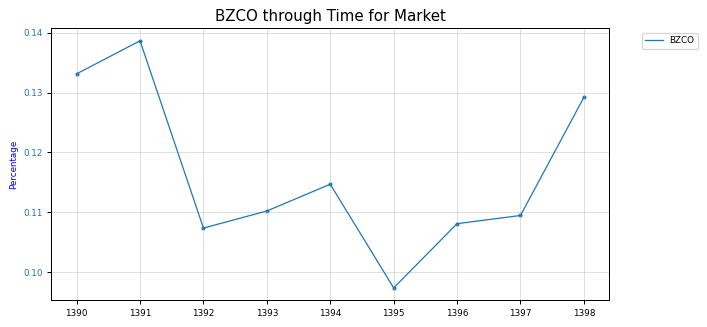

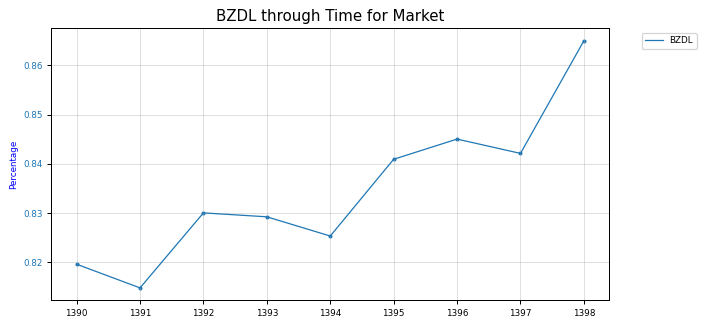

In [119]:
for ocm in OCM:
    plot_trend_Market(ocm)